# ARIMA and SARIMA on Air Passengers Data

### Function to Check Stationarity Using Augmented Dickey-Fuller Test:

In [64]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller_result(series):
    """
    Function To Perform Augmenter Dickey-Fuller Test and Display Results.
    """
    
    result= adfuller(series.dropna())
    
    labels = ["Test Statistics", "p-Value", "No. of Lags", "No. of Observations"]
    
    output = pd.Series(result[0:4], index= labels)
    
    for key,value in result[4].items():
        output[f"Critical Value {key}"] = value
        
    print(output)
    
    print("\n")
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [65]:
import numpy as np
import pandas as pd

from pmdarima import auto_arima

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.tools import diff

from sklearn.metrics import mean_squared_error

In [66]:
df= pd.read_csv("airline_passengers.csv", index_col= 0, parse_dates= True)

In [67]:
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [68]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [69]:
df.index.freq = "MS"

In [70]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

<AxesSubplot:xlabel='Month'>

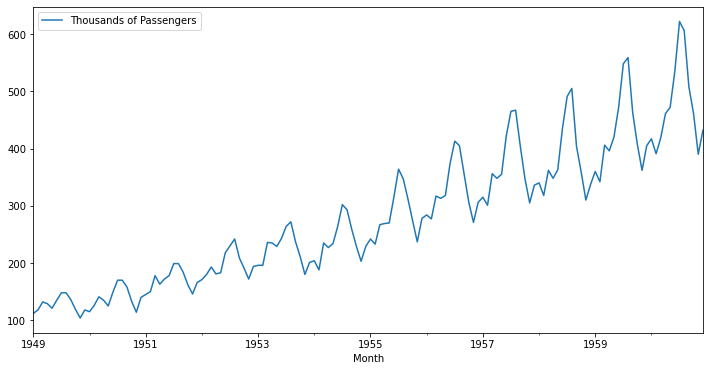

In [71]:
# Plotting Data:

df.plot(figsize= (12,6))

### ETS Decomposition:

In [72]:
decomp = seasonal_decompose(df["Thousands of Passengers"], model= "additive")

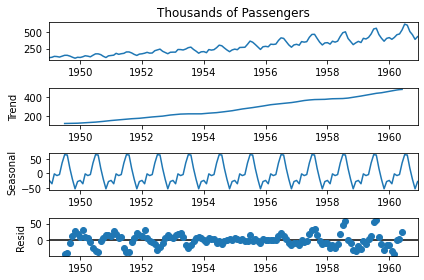

In [73]:
decomp.plot();

### Stationarity Check:

In [74]:
dickey_fuller_result(df["Thousands of Passengers"])

Test Statistics          0.815369
p-Value                  0.991880
No. of Lags             13.000000
No. of Observations    130.000000
Critical Value 1%       -3.481682
Critical Value 5%       -2.884042
Critical Value 10%      -2.578770
dtype: float64


Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [75]:
# Series is Non-Stationary.

# We have to apply Differencing.

In [76]:
df["diff_1"] = diff(df["Thousands of Passengers"], k_diff= 1)

In [77]:
df.head()

,Thousands of Passengers,diff_1
Month,,
1949-01-01,112,NaN
1949-02-01,118,6.0
1949-03-01,132,14.0
1949-04-01,129,-3.0
1949-05-01,121,-8.0


In [78]:
# Checking Stationarity of First Order Differenced Data:

dickey_fuller_result(df["diff_1"])

Test Statistics         -2.829267
p-Value                  0.054213
No. of Lags             12.000000
No. of Observations    130.000000
Critical Value 1%       -3.481682
Critical Value 5%       -2.884042
Critical Value 10%      -2.578770
dtype: float64


Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [79]:
# Applying Second Order Differencing:

df["diff_2"] = diff(df["Thousands of Passengers"], k_diff= 2)

In [80]:
df.head()

,Thousands of Passengers,diff_1,diff_2
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,6.0,NaN
1949-03-01,132,14.0,8.0
1949-04-01,129,-3.0,-17.0
1949-05-01,121,-8.0,-5.0


In [81]:
# Checking Stationarity of Second Order Differenced Data:

dickey_fuller_result(df["diff_2"])

Test Statistics       -1.638423e+01
p-Value                2.732892e-29
No. of Lags            1.100000e+01
No. of Observations    1.300000e+02
Critical Value 1%     -3.481682e+00
Critical Value 5%     -2.884042e+00
Critical Value 10%    -2.578770e+00
dtype: float64


Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### ACF and PACF Plots:

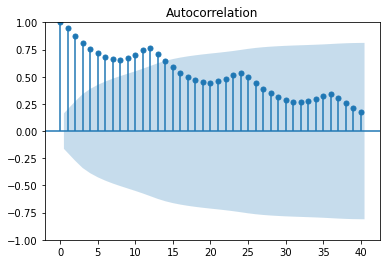

In [82]:
plot_acf(df["Thousands of Passengers"], lags= 40);

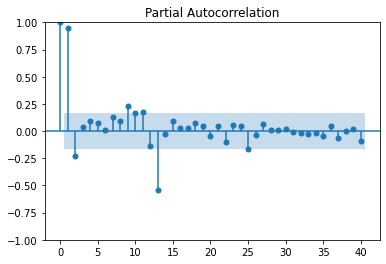

In [83]:
plot_pacf(df["Thousands of Passengers"], lags= 40, method= "ywm");

### Using Auto ARIMA to Decide Orders:

In [84]:
grid_arima = auto_arima(df["Thousands of Passengers"], seasonal= True, m= 12, trace= True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1020.048, Time=0.65 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.11 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=1019.935, Time=0.39 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=1019.290, Time=0.16 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=1019.546, Time=0.37 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1024.160, Time=0.09 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1017.847, Time=0.16 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=1017.914, Time=0.36 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1018.359, Time=0.33 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=1018.248, Time=0.62 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.05 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=1022.393, Time=0.05 sec
 ARIMA(3,1,1)(0,1,0

In [85]:
grid_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                -504.923
Date:                             Thu, 24 Nov 2022   AIC                           1017.847
Time:                                     17:03:22   BIC                           1029.348
Sample:                                 01-01-1949   HQIC                          1022.520
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5960      0.085      6.987      0.000       0.429       0.763
ar.L2          0.2143      0.091      2.344      0.019       0.035       0.394
ma.L1         -0.9819      0.038    -25.601      0.000      -1.057      -0.907
sigma2       129.3080     14.555      8.884      0.000     100.780     157.836
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.68
Prob(Q):                              0.98   Prob(JB):                         0.02
Heteroskedasticity (H):               2.33   Skew:                            -0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [86]:
# So, (p,d,q) = (2,1,1) for ARIMA
# (P,D,Q,m) = (0,1,0,12) for SARIMA

### Train Test Split:

In [87]:
len(df)

144

In [88]:
train_data = df[:132]
test_data = df[132:]

In [89]:
train_data.shape

(132, 3)

In [90]:
test_data.shape

(12, 3)

### 1) ARIMA(2,1,1) Model:

In [91]:
arima_model = ARIMA(train_data["Thousands of Passengers"], order= (2,1,1))

In [92]:
arima_result = arima_model.fit()

In [93]:
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Thousands of Passengers   No. Observations:                  132
Model:                      ARIMA(2, 1, 1)   Log Likelihood                -619.131
Date:                     Thu, 24 Nov 2022   AIC                           1246.262
Time:                             17:03:22   BIC                           1257.763
Sample:                         01-01-1949   HQIC                          1250.936
                              - 12-01-1959                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0698      0.094     11.323      0.000       0.885       1.255
ar.L2         -0.4734      0.101     -4.670      0.000      -0.672      -0.275
ma.L1         -0.8402      0.085     -9.851      0.000      -1.007      -0.673
sigma2       741.2092     92.892      7.979      0.000     559.145     923.274
===================================================================================
Ljung-Box (L1) (Q):                   0.94   Jarque-Bera (JB):                 1.71
Prob(Q):                              0.33   Prob(JB):                         0.42
Heteroskedasticity (H):               6.69   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [94]:
# Predictions on Test Data:

start = len(train_data)
end = len(train_data) + len(test_data) -1

arima_pred = arima_result.predict(start= start, end= end, typ= "levels")

In [95]:
arima_pred

1960-01-01    437.013051
1960-02-01    450.903711
1960-03-01    450.608213
1960-04-01    443.715784
1960-05-01    436.482007
1960-06-01    432.006253
1960-07-01    430.642700
1960-08-01    431.302911
1960-09-01    432.654770
1960-10-01    433.788454
1960-11-01    434.361280
1960-12-01    434.437378
Freq: MS, Name: predicted_mean, dtype: float64

In [96]:
test_data["Thousands of Passengers"]

Month
1960-01-01    417
1960-02-01    391
1960-03-01    419
1960-04-01    461
1960-05-01    472
1960-06-01    535
1960-07-01    622
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Freq: MS, Name: Thousands of Passengers, dtype: int64

<AxesSubplot:xlabel='Month'>

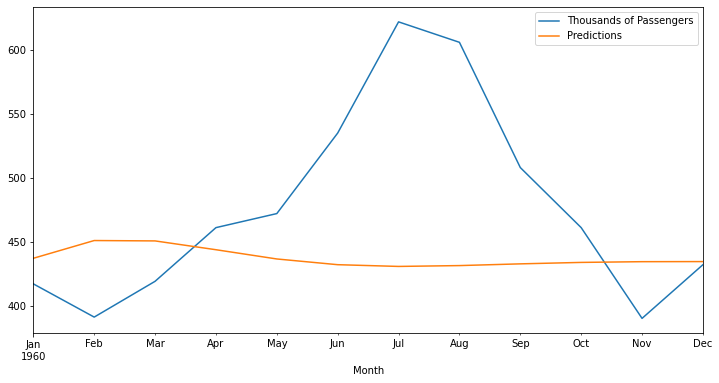

In [97]:
# Plotting Test Data and Predictions:

test_data["Thousands of Passengers"].plot(figsize= (12,6), legend= True)
arima_pred.plot(label= "Predictions", legend= True)

In [98]:
# Model Evaluation:

np.sqrt(mean_squared_error(test_data["Thousands of Passengers"], arima_pred))

87.88437722905219

In [99]:
# Training Model and Full Data and Making Predictions for Future:

final_arima = ARIMA(df["Thousands of Passengers"], order= (2,1,1))

In [100]:
arima_result = final_arima.fit()

In [101]:
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Thousands of Passengers   No. Observations:                  144
Model:                      ARIMA(2, 1, 1)   Log Likelihood                -685.169
Date:                     Thu, 24 Nov 2022   AIC                           1378.338
Time:                             17:03:22   BIC                           1390.190
Sample:                         01-01-1949   HQIC                          1383.154
                              - 12-01-1960                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0907      0.083     13.190      0.000       0.929       1.253
ar.L2         -0.4890      0.097     -5.046      0.000      -0.679      -0.299
ma.L1         -0.8439      0.073    -11.486      0.000      -0.988      -0.700
sigma2       844.6059    103.095      8.192      0.000     642.543    1046.669
===================================================================================
Ljung-Box (L1) (Q):                   0.94   Jarque-Bera (JB):                 2.15
Prob(Q):                              0.33   Prob(JB):                         0.34
Heteroskedasticity (H):               7.67   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [102]:
# Forecasting:

forecast_arima = arima_result.predict(start= len(df), end= len(df)+11, typ= "levels")

In [103]:
forecast_arima

1961-01-01    471.000383
1961-02-01    492.998177
1961-03-01    497.918890
1961-04-01    492.528738
1961-05-01    484.243730
1961-06-01    477.843463
1961-07-01    474.914377
1961-08-01    474.849500
1961-09-01    476.211067
1961-10-01    477.727786
1961-11-01    478.716191
1961-12-01    479.052519
Freq: MS, Name: predicted_mean, dtype: float64

<AxesSubplot:xlabel='Month'>

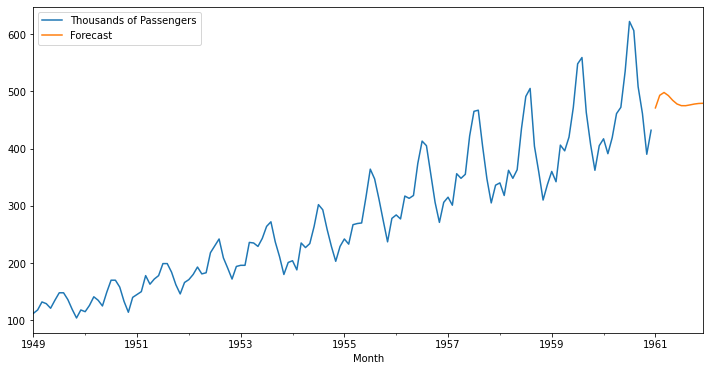

In [104]:
# Plotting Historic and Forecast Data:

df["Thousands of Passengers"].plot(figsize= (12,6), legend= True)
forecast_arima.plot(label= "Forecast", legend= True)

### 1) SARIMA(2,1,1)(0,1,0,12) Model:

In [105]:
sarima_model = SARIMAX(train_data["Thousands of Passengers"], order= (2,1,1), seasonal_order= (0,1,0,12))

In [106]:
sarima_result = sarima_model.fit()

C:\Users\Shailya\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Shailya\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [107]:
sarima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:             Thousands of Passengers   No. Observations:                  132
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                -447.483
Date:                             Thu, 24 Nov 2022   AIC                            902.967
Time:                                     17:03:23   BIC                            914.083
Sample:                                 01-01-1949   HQIC                           907.481
                                      - 12-01-1959                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5253      0.929     -0.566      0.572      -2.345       1.295
ar.L2          0.0110      0.275      0.040      0.968      -0.529       0.551
ma.L1          0.3064      0.935      0.328      0.743      -1.527       2.140
sigma2       108.0094     13.498      8.002      0.000      81.553     134.466
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.39
Prob(Q):                              0.97   Prob(JB):                         0.50
Heteroskedasticity (H):               1.47   Skew:                            -0.09
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [108]:
# Predictions on Test Data:

start = len(train_data)
end = len(train_data) + len(test_data) -1

sarima_pred = sarima_result.predict(start= start, end= end, typ= "levels")

In [109]:
sarima_pred

1960-01-01    425.135147
1960-02-01    408.815435
1960-03-01    471.901435
1960-04-01    462.399947
1960-05-01    486.128076
1960-06-01    538.276345
1960-07-01    614.195484
1960-08-01    625.239583
1960-09-01    529.215533
1960-10-01    473.228649
1960-11-01    428.221496
1960-12-01    471.225397
Freq: MS, Name: predicted_mean, dtype: float64

<AxesSubplot:xlabel='Month'>

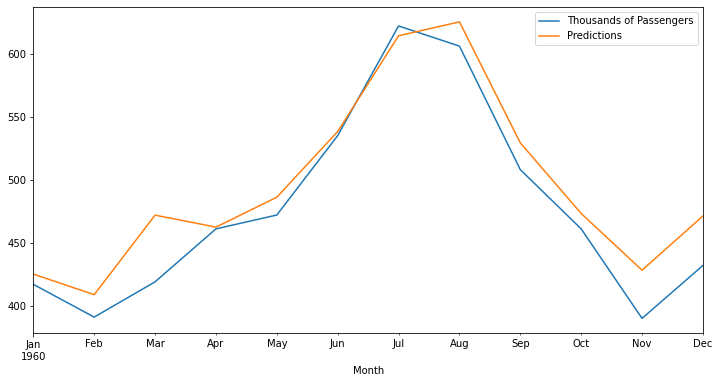

In [110]:
# Plotting Test Data and Predictions:

test_data["Thousands of Passengers"].plot(figsize= (12,6), legend= True)
sarima_pred.plot(label= "Predictions", legend= True)

In [111]:
# Model Evaluation:

np.sqrt(mean_squared_error(test_data["Thousands of Passengers"], sarima_pred))

24.874106758116593

In [112]:
# Training Model and Full Data and Making Predictions for Future:

final_sarima = SARIMAX(df["Thousands of Passengers"], order= (2,1,1), seasonal_order= (0,1,0,12))

In [113]:
sarima_result = final_sarima.fit()

C:\Users\Shailya\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Shailya\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [114]:
sarima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:             Thousands of Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                -504.923
Date:                             Thu, 24 Nov 2022   AIC                           1017.847
Time:                                     17:03:23   BIC                           1029.348
Sample:                                 01-01-1949   HQIC                          1022.520
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5960      0.085      6.987      0.000       0.429       0.763
ar.L2          0.2143      0.091      2.344      0.019       0.035       0.394
ma.L1         -0.9819      0.038    -25.601      0.000      -1.057      -0.907
sigma2       129.3080     14.555      8.884      0.000     100.780     157.836
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.68
Prob(Q):                              0.98   Prob(JB):                         0.02
Heteroskedasticity (H):               2.33   Skew:                            -0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [115]:
# Forecasting:

forecast_sarima = sarima_result.predict(start= len(df), end= len(df)+11, typ= "levels")

In [116]:
forecast_sarima

1961-01-01    445.634921
1961-02-01    420.394986
1961-03-01    449.198307
1961-04-01    491.839934
1961-05-01    503.394465
1961-06-01    566.862442
1961-07-01    654.260170
1961-08-01    638.597486
1961-09-01    540.883744
1961-10-01    494.126627
1961-11-01    423.332720
1961-12-01    465.507591
Freq: MS, Name: predicted_mean, dtype: float64

<AxesSubplot:xlabel='Month'>

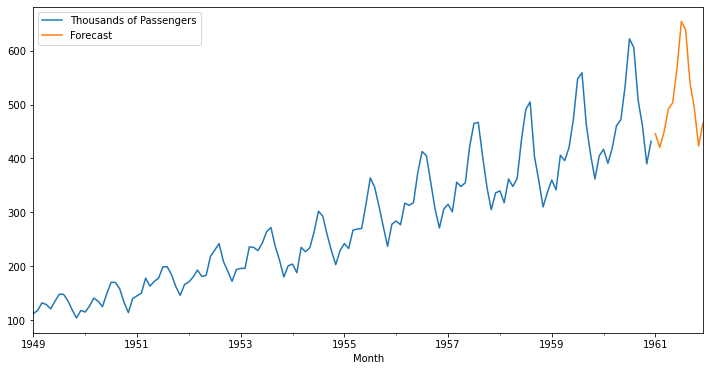

In [117]:
# Plotting Historic and Forecast Data:

df["Thousands of Passengers"].plot(figsize= (12,6), legend= True)
forecast_sarima.plot(label= "Forecast", legend= True)

### Comparing Predictions and Forecast of ARIMA and SARIMA:

<AxesSubplot:xlabel='Month'>

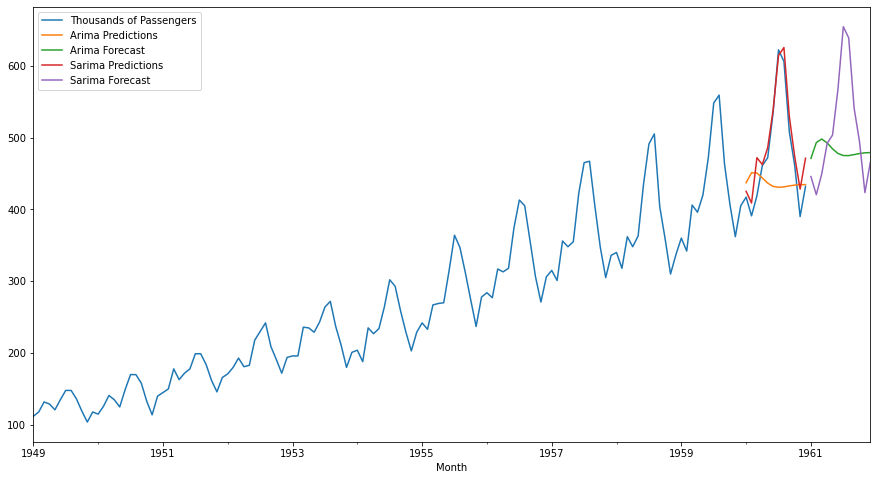

In [118]:
df["Thousands of Passengers"].plot(figsize= (15,8), legend= True)

arima_pred.plot(label= "Arima Predictions", legend= True)
forecast_arima.plot(label= "Arima Forecast", legend= True)

sarima_pred.plot(label= "Sarima Predictions", legend= True)
forecast_sarima.plot(label= "Sarima Forecast", legend= True)